# Prediction: Beyond Simple Random Walks

The tracking algorithm, at its simplest level, takes each particle in the previous frame and tries to find it in the current frame. This requires knowing where to look for it; if we find an actual particle near that spot, it's probably a match. The basic algorithm (Crocker & Grier) was developed to track particles undergoing Brownian diffusion, which ideally means that a particle's velocity is uncorrelated from one frame to the next. Therefore, the best guess for where a particle is going is that it will be near its most recent location.

Let's formalize this guessing as *prediction*. Consider a function

$$P(t_1, t_0, \vec x(t_0))$$

that takes the particle at position $\vec x(t_0)$ and predicts its future position $\vec x(t_1)$. The optimal predictor for Brownian motion is

$$P(t_1, t_0, \vec x(t_0)) = \vec x(t_0)$$

which happily is also the easiest to implement.

The better our prediction about where to look in the next frame, the more likely we will find the one and only particle we seek. `trackpy` looks for the particle in a small region of radius `search_range`, centered on $P(t_1, t_0, \vec x(t_0))$. So to successfully track particle $i$ puts a limit on the error in our prediction:

$$\|P(t_1, t_0, \vec x_i(t_0)) - \vec x_i(t_1)\| \le \tt{search\_range}$$

This favors a generous `search_range`. However, if `search_range` is too big, then for each particle in the previous frame there will be many possible matches in the current frame, and so matching one frame to the next requires the computer to consider a mind-boggling set of possibilities. Tracking may become impossibly slow, and this causes `trackpy` to halt and raise a `SubnetOversizeException`, rather than keep you waiting forever. So for the Brownian $P$ above, `search_range` must be bigger than the largest particle displacement between frames, but smaller than the typical spacing between particles. If such a value cannot be found among the real numbers, then you have a problem.

However, if particle motion is not strictly Brownian, its velocity probably *is* correlated in time. We may be able to improve $P$. We will now do this with `trackpy`.

## Prescribed predictors

Let's start by demonstrating the mechanics of $P$ in `trackpy`. `trackpy`'s various `link_` functions accept a `predictor` argument, which is a Python function that implements $P$.

Before we see how, let's fake some data: a regular array of particles, translating with constant velocity.

In [1]:
from pylab import *
import numpy as np
import pandas

def fakeframe(t=0, Nside=4):
    xg, yg = np.mgrid[:Nside,:Nside]
    dx = 1 * t
    dy = -1 * t
    return pandas.DataFrame(
            dict(x=xg.flatten() + dx, y=yg.flatten() + dy, frame=t))

Let's visualize 2 frames. In all of the plots below, the blue circles are the particles of the first frame and the green squares are the particles of the last frame.

(-1.0, 3.5)

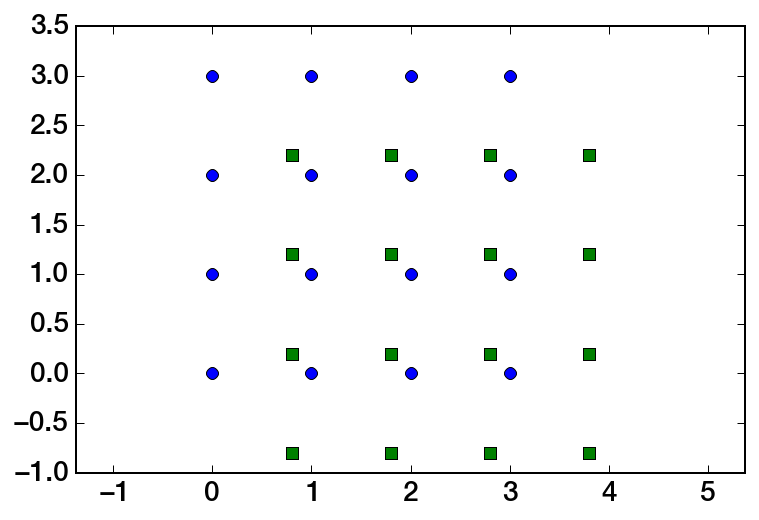

In [2]:
f0 = fakeframe(0)
f1 = fakeframe(0.8)
plot(f0.x, f0.y, 'bo')
plot(f1.x, f1.y, 'gs')
axis('equal'); ylim(ymin=-1.0, ymax=3.5)

Track and visualize.

In [3]:
import trackpy
tr = pandas.concat(trackpy.link_df_iter((f0, f1), 0.5))

Frame 0: 16 trajectories present


In [4]:
def trshow(tr, first_style='bo', last_style='gs', style='b.'):
    frames = list(tr.groupby('frame'))
    nframes = len(frames)
    for i, (fnum, pts) in enumerate(frames):
        if i == 0:
            sty = first_style
        elif i == nframes - 1:
            sty = last_style
        else:
            sty = style
        plot(pts.x, pts.y, sty)
    trackpy.plot_traj(tr, colorby='frame', ax=gca())
    axis('equal'); ylim(ymin=-1.0, ymax=3.5)
    xlabel('x')
    ylabel('y')

Drawing multicolor lines takes awhile. Come back in a minute.


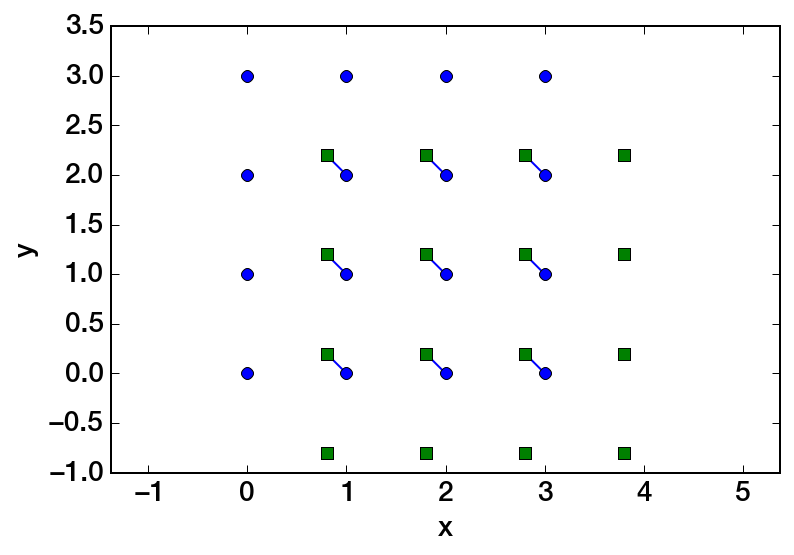

In [5]:
trshow(tr)

Obviously this is not what we wanted at all! Let's give `trackpy.link_df_iter()` a $P$ which reflects this constant velocity.

We define `predict()` for a single particle, and use the `trackpy.predict.predictor` decorator to let it make predictions for many particles at once. Then, we pass it to `link_df_iter()` via the `predictor` argument.

Drawing multicolor lines takes awhile. Come back in a minute.


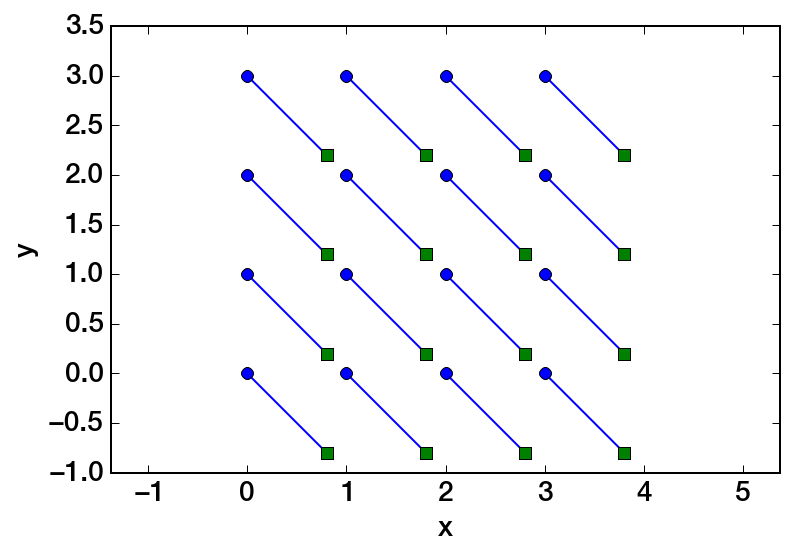

In [6]:
import trackpy.predict

@trackpy.predict.predictor
def predict(t1, particle):
    velocity = np.array((1, -1)) # See fakeframe()
    return particle.pos + velocity * (t1 - particle.t)

tr = pandas.concat(trackpy.link_df_iter((f0, f1), 0.5, predictor=predict))
trshow(tr)

Yay! Remember: Our predictor doesn't have to know exactly where the particle will be; it just has to bias the search enough that the correct identification will be made.

## Dynamic predictors

Of course, it's rare that you will know your particles' velocities ahead of time. It would be much better for the predictor to "learn" about the velocities, and allow different particles to have different velocities that can change over time. To accomplish this, we have to do more than just supply $P$: we have to know particles' most recent velocities.

$$P(t_1, t_0, \vec x_i(t_0)) = \vec x_i(t_0) + \frac{\vec x_i(t_0) - \vec x_i(t_{-1})}{t_0 - t_{-1}} (t_1 - t_0)$$

To implement this kind of prediction in `trackpy`, we use instances of the `trackpy.predict.NearestVelocityPredict` class.

There are a few caveats:

- Defining this new $P$ for particle $i$ specifically is problematic, because if a new particle is in frame $t_0$ but wasn't in $t_{-1}$, we won't know its velocity. So newly-appeared particles just borrow the velocity of the closest old particle.

- Velocities are undefined in the first frame of the movie, because there is no previous frame. The code falls back to an initial guess of $\vec v_0 = 0$. However, `NearestVelocityPredict`, and the other classes in `trackpy.predict`, allow one to instead specify an initial velocity profile, field, etc. See the docstring of each class.

- Even though particles may be in motion at the start of the movie, the default of $\vec v_0 = 0$ is not always so bad. In many cases, at least some of the particles are moving slowly enough that they can be tracked and their velocity can be obtained. Because particles with unknown velocity just borrow the nearest known velocity, as we just discussed, this may give the code a foothold to track more particles in later frames. Your mileage may vary.

OK, let's see this in action. We'll make a 3-frame movie that starts with small displacements (because of the $\vec v_0 = 0$ assumption) and then speeds up.

In [7]:
frames = (fakeframe(0), fakeframe(0.25), fakeframe(0.65))

Without prediction, linking of the particles in the top row can't even make it to the 3rd frame.

Drawing multicolor lines takes awhile. Come back in a minute.


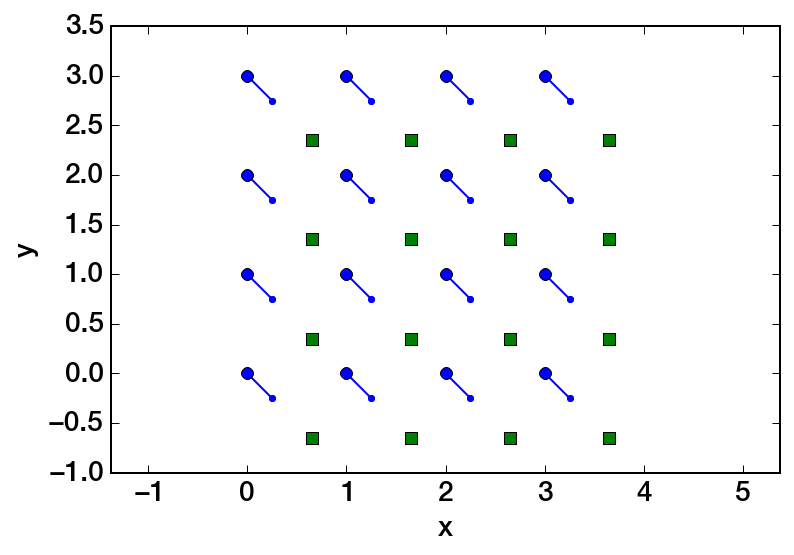

In [8]:
tr = pandas.concat(trackpy.link_df_iter(frames, 0.5))
trshow(tr)

`NearestVelocityPredict` objects work by watching the output of linking as it happens, and updating $P$ to use the latest velocities. These objects provide modified versions of trackpy's two main linking functions, `link_df_iter()` and `link_df()`, that work like their namesakes but add dynamic prediction.

First, we use `link_df_iter()` to link the frames with prediction:

Drawing multicolor lines takes awhile. Come back in a minute.


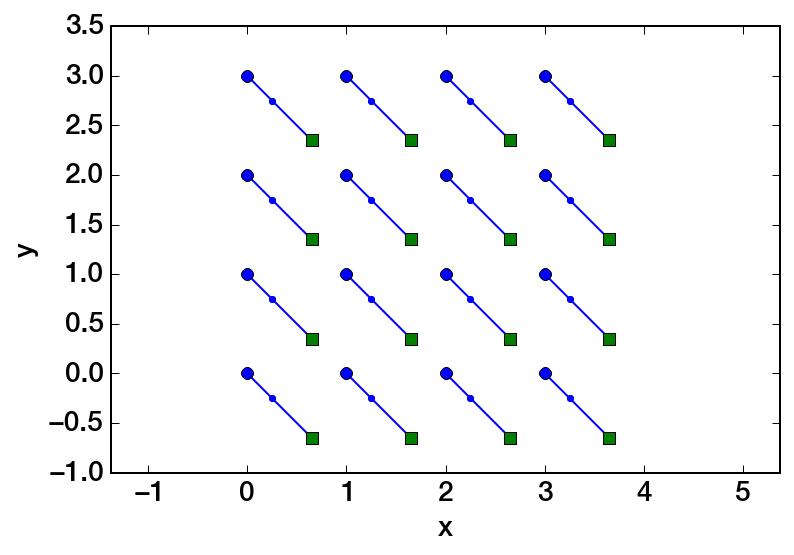

In [9]:
pred = trackpy.predict.NearestVelocityPredict()
tr = pandas.concat(pred.link_df_iter(frames, 0.5))
trshow(tr)

Alternatively, we can use `link_df()`:

Drawing multicolor lines takes awhile. Come back in a minute.


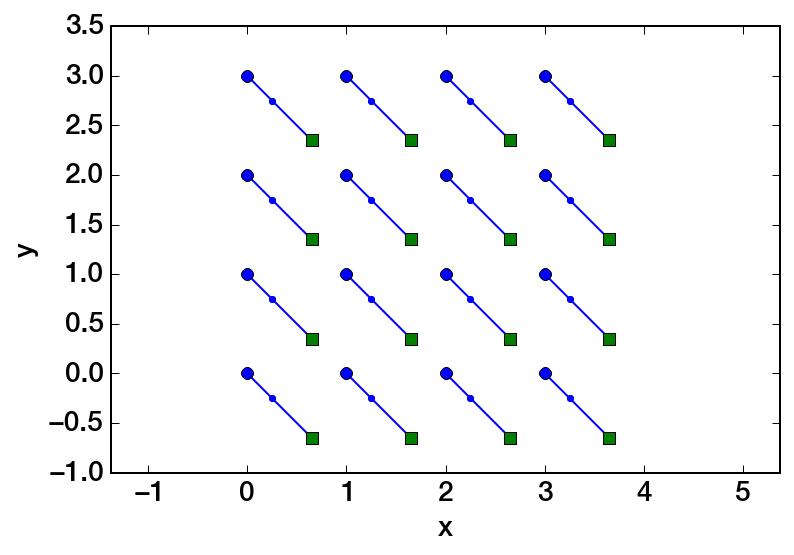

In [10]:
pred = trackpy.predict.NearestVelocityPredict()
tr = pred.link_df(pandas.concat(frames), 0.5)
trshow(tr)

We'll use `link_df_iter()` for the remaining examples, but `link_df()` is always available as well.

(*Note:* Unlike `link_df_iter()`, this `link_df()` is usually — but not always — a drop-in replacment for `trackpy.link_df()`. Consult the documentation or source code for details.)

### Channel flow prediction

There is one special case that is common enough to deserve a special $P$: channel flow, in which velocities are relatively uniform in one direction. For example, if the channel is in the $x$ (i.e. $\hat i$) direction, particle velocities are very well approximated as

$$\vec v = \hat i v_x(y)$$

where the velocity profile $v_x(y)$ is a smoothly-varying function defined across the channel.

This is implemented by the `trackpy.predict.ChannelPredict` class. When creating an instance, you must specify the size of the bins used to create the velocity profile. You can also specify the direction of flow; see the class's docstring for details.

Let's create some particles undergoing accelerating shear.

In [11]:
def fakeshear(t=0, Nside=4):
    xg, yg = np.mgrid[:Nside,:Nside]
    dx = 0.45 * t * yg
    return pandas.DataFrame(
            dict(x=(xg + dx).flatten(), y=yg.flatten(), frame=t))

When we attempt to track them, the algorithm fails for the top row of particles.

Drawing multicolor lines takes awhile. Come back in a minute.


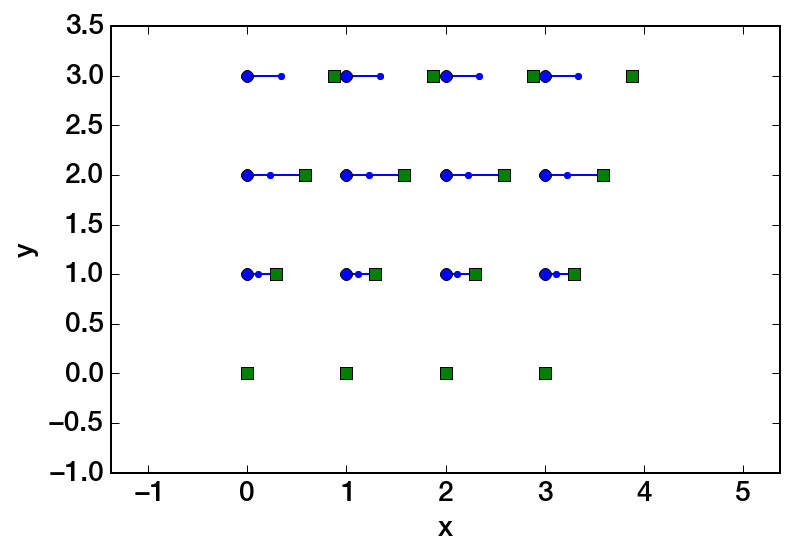

In [12]:
frames = (fakeshear(0), fakeshear(0.25), fakeshear(0.65))
tr = pandas.concat(trackpy.link_df_iter(frames, 0.5))
trshow(tr)
ylim(ymax=3.5);

Now, let's try it with prediction:

Drawing multicolor lines takes awhile. Come back in a minute.


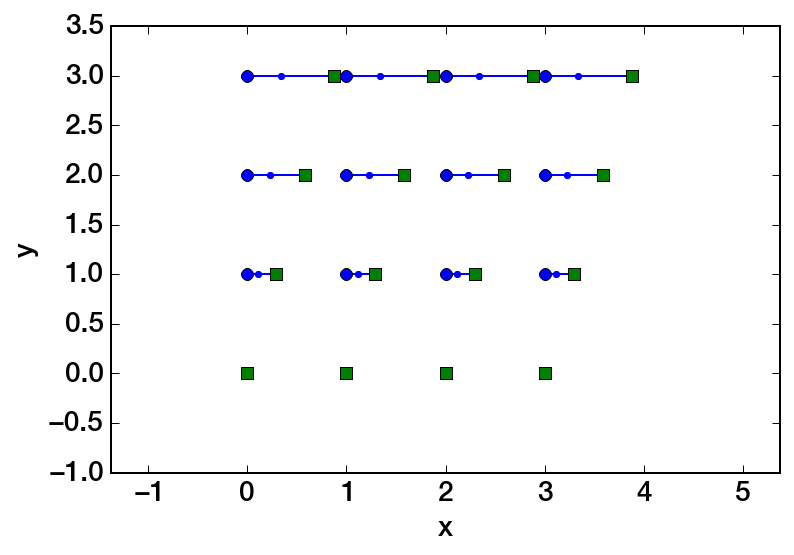

In [13]:
pred = trackpy.predict.ChannelPredict(0.5, 'x', minsamples=3)
tr = pandas.concat(pred.link_df_iter(frames, 0.5))
trshow(tr)
ylim(ymax=3.5);

Much better!

### Drift prediction

Finally, the most symmetric prediction class in `trackpy.predict` is `DriftPredict`. This just makes predictions based on the average velocity of all particles. It is useful when you have some background convective flow that you'd like to ignore.